In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.config.list_physical_devices('GPU'))

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

2022-10-05 15:06:38.917547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 15:06:39.109032: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-05 15:06:39.786776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jetcalz07/anaconda3/lib/python3.9/site-packages/cv2/../../lib64::/home/jetcalz07/anaconda3/envs/sf_dd/lib/:/home/jetcalz07/anaconda3/envs/sf_dd/lib/:/home/jetcalz07/anaconda3/envs/sf_dd/lib/:/home/jetcalz07

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-10-05 15:06:41.226235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 15:06:41.237080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 15:06:41.237341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
train_dir = '/home/jetcalz07/state_farm_distracted_driver/data/imgs/train/'
test_dir = '/home/jetcalz07/state_farm_distracted_driver/data/imgs/test/'

In [3]:
# Function to read indiv image
def get_cv2_image(path, img_rows, img_cols, color_type=1):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

In [4]:
num_classes = 10
classes = ['c' + str(x) for x in range(num_classes)]

# Load train batch into image and label arrays
def load_train(img_rows, img_cols, color_type=1):
    train_imgs = []
    train_labels = []
    
    # Go through each folder
    i = 0
    for class_ in classes:
        files = glob(os.path.join(train_dir, class_, '*.jpg'))
        for file in tqdm(files):
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_imgs.append(img)
            train_labels.append(i)
        i += 1
            
    return train_imgs, train_labels


# Split into train and val
def normalize_and_split_train_val(img_rows, img_cols, color_type=1):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Convert dtype and reshape for batches
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_val = np.array(x_val, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_val, y_train, y_val
    
    
# Same for test
def load_test(img_rows, img_cols, color_type=1, size=200000):
    test_data = []
    test_files = []
    
    files = glob(os.path.join(test_dir, '*.jpg'))
    total = 0
    for file in files:
        if total >= size:
            break
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        test_data.append(img)
        test_files.append(file)
        total += 1
            
    return test_data, test_files

def read_and_normalize_test_data(img_rows, img_cols, color_type=1, size=200000):
    test_data, test_files = load_test(img_rows, img_cols, color_type, size)
    test_data = np.array(test_data, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_files

100%|█████████████████████████████████████| 2129/2129 [00:03<00:00, 651.84it/s]


X Train shape: (17939, 128, 128, 1)
Y Train shape: (17939, 10)
X Val shape: (4485, 128, 128, 1)
Y Val shape: (4485, 10)

Sample Image Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


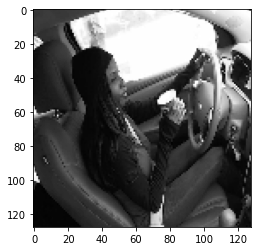

In [5]:
img_rows = 128
img_cols = 128
color_type = 1

#train_imgs, train_labels = load_train(img_rows, img_cols, color_type)
x_train, x_val, y_train, y_val = normalize_and_split_train_val(img_rows, img_cols, color_type)
print('X Train shape:', x_train.shape)
print('Y Train shape:', y_train.shape)
print('X Val shape:', x_val.shape)
print('Y Val shape:', y_val.shape)

print(f"\nSample Image Label: {y_train[0]}")
plt.imshow(x_train[0], cmap='gray')

### Simple CNN

In [6]:
def build_simple_cnn(input_shape, batch_size, kernel_size, filters, pool_size, dropout, num_labels):
    inputs = Input(shape=(input_shape))
    
    # Conv + Pool #1
    conv1 = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(inputs)
    maxp1 = MaxPooling2D(pool_size)(conv1)
    
    # Conv + Pool #2
    conv2 = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(maxp1)
    maxp2 = MaxPooling2D(pool_size)(conv2)
    
    # Flatten + Dropoout
    flat = Flatten()(maxp2)
    drop = Dropout(dropout)(flat)
    
    # Fully Connected
    outputs = Dense(num_labels, activation = 'softmax')(drop)
    
    # Build
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [7]:
size_x = x_train.shape[1]
size_y = x_train.shape[2]
input_shape = (size_x, size_y, 1)
batch_size = 128
kernel_size = 3
pool_size=(2, 2)
filters = 64
dropout = 0.3
num_labels = 10

def build_simple_cnn(input_shape, batch_size, kernel_size, filters, pool_size, dropout, num_labels):
    inputs = Input(shape=(input_shape))
    
    # Conv + Pool #1
    conv1 = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(inputs)
    maxp1 = MaxPooling2D(pool_size)(conv1)
    
    # Conv + Pool #2
    conv2 = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(maxp1)
    maxp2 = MaxPooling2D(pool_size)(conv2)
    
    # Flatten + Dropoout
    flat = Flatten()(maxp2)
    drop = Dropout(dropout)(flat)
    
    # Fully Connected
    outputs = Dense(num_labels, activation = 'softmax')(drop)
    
    # Build
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

simple_cnn = build_simple_cnn(input_shape, batch_size, kernel_size, filters, pool_size, dropout, num_labels)
history = simple_cnn.fit(x_train,
                           y_train,
                           validation_data=(x_val, y_val),
                           epochs=10,
                           batch_size=batch_size)

2022-10-05 15:07:16.821213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 15:07:16.822551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 15:07:16.822896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 15:07:16.823148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/10


2022-10-05 15:07:21.181495: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-05 15:07:23.606762: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-05 15:07:23.607460: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-05 15:07:23.607499: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-05 15:07:23.608090: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-05 15:07:23.608189: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


141/141 [==============================] - 17s 68ms/step - loss: 9.0555 - accuracy: 0.7509 - val_loss: 0.1087 - val_accuracy: 0.9701
Epoch 2/10
141/141 [==============================] - 9s 65ms/step - loss: 0.0939 - accuracy: 0.9708 - val_loss: 0.0810 - val_accuracy: 0.9775
Epoch 3/10
141/141 [==============================] - 9s 65ms/step - loss: 0.0712 - accuracy: 0.9797 - val_loss: 0.0488 - val_accuracy: 0.9895
Epoch 4/10
141/141 [==============================] - 9s 65ms/step - loss: 0.0586 - accuracy: 0.9819 - val_loss: 0.0664 - val_accuracy: 0.9831
Epoch 5/10
141/141 [==============================] - 9s 65ms/step - loss: 0.0516 - accuracy: 0.9851 - val_loss: 0.0525 - val_accuracy: 0.9904
Epoch 6/10
141/141 [==============================] - 9s 65ms/step - loss: 0.0687 - accuracy: 0.9796 - val_loss: 0.0827 - val_accuracy: 0.9826
Epoch 7/10
141/141 [==============================] - 9s 65ms/step - loss: 0.0771 - accuracy: 0.9793 - val_loss: 0.0693 - val_accuracy: 0.9851
Epoch 8/1

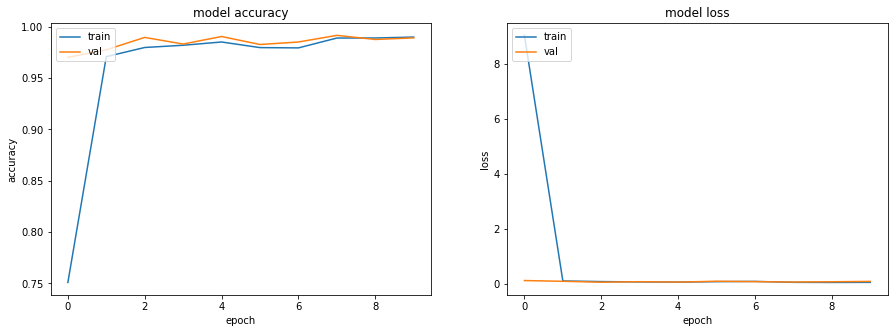

In [8]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('model accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')

    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('model loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')

    plt.show()
    
plot_history(history)

In [14]:
## Handle Submission
def evaluate_test(model, nb_test_samples):
    # Load test data
    x_test, test_files = read_and_normalize_test_data(img_rows, img_cols, color_type, nb_test_samples)
    print('Test shape:', x_test.shape)

    # Create batches to avoid GPU OOM on large test set
    batch_size = 512
    steps = x_test.shape[0] // batch_size
    print(f"# of steps in test: {steps+1}")

    # Predict and save df
    preds_df = pd.DataFrame()
    for step in tqdm(range(steps)):
        if step < (steps-1):
            x_test_batch = x_test[batch_size*step:batch_size*(step+1)]
            test_files_batch = test_files[batch_size*step:batch_size*(step+1)]
        else:
            x_test_batch = x_test[batch_size*step:]
            test_files_batch = test_files[batch_size*step:]
        preds = model.predict_on_batch(x_test_batch)

        # Create df and append to master df
        sub_df = pd.DataFrame(preds)
        sub_df.columns = [f'c{x}' for x in range(10)]
        sub_df['img'] = [os.path.basename(x) for x in test_files_batch]
        cols = sub_df.columns.to_list()
        sub_df = sub_df[cols[-1:] + cols[0:-1]]
        
        preds_df = pd.concat([preds_df, sub_df], axis = 0)
    print(f"Shape Preds: {preds_df.shape}")
        
    return preds_df

In [16]:
try:
    del x_train, x_val, y_train, y_val
except:
    pass

## Evaluate test, save
nb_test_samples = len(os.listdir(test_dir))
#nb_test_samples = 6000
preds_df = evaluate_test(simple_cnn, nb_test_samples)
preds_df.to_csv('./test_preds/preds_simple_cnn.csv', index=False)
preds_df.head()

Test shape: (79726, 128, 128, 1)
# of steps in test: 156


100%|████████████████████████████████████████| 155/155 [00:13<00:00, 11.13it/s]


Shape Preds: (79726, 11)


,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_42245.jpg,3.055583e-02,2.194906e-01,5.207130e-20,7.436866e-01,6.266944e-03,7.223173e-15,3.787548e-13,9.970565e-13,1.960983e-08,2.256550e-10
1,img_16938.jpg,1.946630e-05,3.704671e-03,2.351381e-14,2.733049e-03,9.893783e-01,4.076703e-13,4.164526e-03,5.671668e-09,2.030153e-12,1.140378e-12
2,img_65608.jpg,4.456624e-09,3.851933e-08,3.539963e-11,4.942083e-09,5.158971e-04,7.914755e-01,1.930152e-01,7.932700e-11,3.790515e-08,1.499318e-02
3,img_29335.jpg,8.771481e-10,5.108962e-12,2.838438e-17,6.260374e-15,4.871630e-09,3.179444e-14,1.000000e+00,6.058532e-12,1.157205e-11,1.618041e-23
4,img_793.jpg,1.667519e-05,1.349494e-13,2.456014e-10,2.610706e-10,9.637632e-14,7.807764e-08,8.532557e-11,6.777809e-09,3.816532e-12,9.999832e-01


In [17]:
# Submit to kaggle thru CLI
!kaggle competitions submit -c state-farm-distracted-driver-detection -f ./test_preds/preds_simple_cnn.csv -m "first_submission"

/bin/bash: /home/jetcalz07/anaconda3/envs/sf_dd/lib/libtinfo.so.6: no version information available (required by /bin/bash)
100%|██████████████████████████████████████| 11.0M/11.0M [00:01<00:00, 8.53MB/s]
Successfully submitted to State Farm Distracted Driver Detection

### Simple CNN + Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   rotation_range=20,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/ 255)

training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

cnn_datagen = build_simple_cnn(input_shape, batch_size, kernel_size, filters, pool_size, dropout, num_labels)
history = cnn_datagen.fit_generator(training_generator,
                                     steps_per_epoch = x_train.shape[0] // batch_size,
                                     epochs = 20, 
                                     verbose = 1,
                                     validation_data = val_generator,
                                     validation_steps = x_val.shape[0] // batch_size)

In [ ]:
plot_history(history)

In [ ]:
## Evaluate test, save
nb_test_samples = len(os.listdir(test_dir))
#nb_test_samples = 6000
preds_df = evaluate_test(cnn_datagen, nb_test_samples)
preds_df.to_csv('./test_preds/preds_simple_cnn_aug.csv', index=False)
preds_df.head()

In [ ]:
# Submit to kaggle thru CLI
!kaggle competitions submit -c state-farm-distracted-driver-detection -f ./test_preds/preds_simple_cnn_aug.csv -m "aug_submission"

### Code Garage

In [ ]:
# # Same for test
# def load_test_batch(img_rows, img_cols, start, end, color_type=1):
#     test_data = []
#     test_files = []
    
#     files = glob(os.path.join(test_dir, '*.jpg'))
#     total = 0
#     for file in files[start:end]:
#         img = get_cv2_image(file, img_rows, img_cols, color_type)
#         test_data.append(img)
#         test_files.append(file)
#         total += 1
            
#     return test_data, test_files

# def read_reshape_test_batch(img_rows, img_cols, start, end, color_type=1):
#     test_data, test_files = load_test_batch(img_rows, img_cols, start, end, color_type)
#     test_data = np.array(test_data, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
#     return test_data, test_files